In [26]:
# %load CompareVariablesOldNewMCfiles.py
import ROOT as r
import os

directory = {'old':'/disk/lhcb_data2/RLcMuonic2016/MC_full_new/','new':'/disk/lhcb_data2/RLcMuonic2016/MC_full_trueTrigger/',
             'MCfull':'/disk/lhcb_data2/RLcMuonic2016/MC_full_trueTrigger/','MCTO':'/disk/lhcb_data2/RLcMuonic2016/MC_TrackerOnly/'}
mcsamples  = ['Lb_Lcmunu','Lb_Lctaunu','Lb_LcDs','Lb_Lc2593munu','Lb_Lc2593taunu','Lb_Lc2593Ds','Lb_Lc2625munu','Lb_Lc2625taunu','Lb_Lc2625Ds']
polarities = ['MagUp','MagDown']

variables = ['Lb_HLt1TwoTrackMVAEmulations_1_2','Lb_HLt1TwoTrackMVAEmulations_1_3',
             'Lb_HLt1TwoTrackMVAEmulations_1_4','Lb_HLt1TwoTrackMVAEmulations_2_3',
             'Lb_HLt1TwoTrackMVAEmulations_2_4','Lb_HLt1TwoTrackMVAEmulations_3_4']

def PutTogetherPolarityHistos(h):
    h_new = {}
    for mcsample in mcsamples:
        if(h[mcsample]['MagUp']):
            h_new[mcsample] = h[mcsample]['MagUp']
            if(h[mcsample]['MagDown']):
                h_new[mcsample].Add(h[mcsample]['MagDown'])
                h_new[mcsample].SetTitle(mcsample)
                h_new[mcsample].SetDirectory(0)
    return h_new


def PlotSuperimposedSingle(var,hold, hnew):
    c = r.TCanvas('c_'+var,'c_'+var)
    hold.SetLineColor(r.kAzure+9)
    hnew.SetLineColor(r.kOrange+2)
    hold.Draw('hist')
    hnew.Draw('hist sames')
    l = r.TLegend()
    l.AddEntry(hold,'old file','l')
    l.AddEntry(hnew,'new file','l')
    l.Draw('same')
    return c

In [2]:
def ScaleHistos(h, h1, value):
    for key in variables:
        print(key)
        for mcsample in mcsamples:
            scale = value/h[key][mcsample].Integral()
            h[key][mcsample].Scale(scale)
            scale2 = value/h1[key][mcsample].Integral()
            h1[key][mcsample].Scale(scale2)
    return h, h1

In [3]:
#not used
def CompareAllVariables():
    parentdir = os.getcwd()
    for mcsample in mcsamples:
        for polarity in polarities:
            plotdir = 'ComparisonPlots/'+mcsample+'/'+polarity
            path = os.path.join(parentdir, plotdir)
            try:
                os.makedirs(path)
            except OSError:
                print('Directory already existing')
            else:
                print("Successfully created the directory %s" % path)
            fold = r.TFile(directory['old']+mcsample+'_'+polarity+'_full.root','READ')
            told = fold.Get('tupleout/DecayTree')
            fnew = r.TFile(directory['new']+mcsample+'_'+polarity+'.root','READ')
            tnew = fnew.Get('tupleout/DecayTree')

            branches = told.GetListOfBranches()
            for i in range(branches.GetEntries()):
                cname = 'c_'+branches.At(i).GetName()+'_'+mcsample+'_'+polarity 
                c = r.TCanvas(cname,cname,500,500)
                told.Draw(branches.At(i).GetName())
                tnew.Draw(branches.At(i).GetName(),'','sames')
                r.gPad.GetListOfPrimitives().At(1).SetLineColor(2);
                c.SaveAs(path+'/'+cname+'.png')

In [4]:
#not used
def CompareVariables():
    c = {}
    for mcsample in mcsamples:
        c[mcsample] = {}
        for polarity in polarities:
            fMCfull = r.TFile(directory['MCfull']+mcsample+'_'+polarity+'_full.root','READ')
            tMCfull = fMCfull.Get('tupleout/DecayTree')
            tMCfull.SetBranchStatus('*',0)
            fMCTO = r.TFile(directory['MCTO']+mcsample+'_'+polarity+'.root','READ')
            tMCTO = fMCTO.Get('tupleout/DecayTree')
            tMCTO.SetBranchStatus('*',0)
            c[mcsample][polarity]={}
            for variable in variables:
                tMCfull.SetBranchStatus(variable,1)
                tMCTO.SetBranchStatus(variable,1)
                cname = 'c_'+variable+'_'+mcsample+'_'+polarity 
                c[mcsample][polarity][variable] = r.TCanvas(cname,cname,500,500)
                tMCfull.Draw(variable)
                tMCTO.Draw(variable,'','sames')
                r.gPad.GetListOfPrimitives().At(1).SetLineColor(2);
                #c.SaveAs(path+'/'+cname+'.png')
    return c

In [5]:
def GetHistograms(variable,MCtype1,MCtype2):
    h = {mcsample: {polarity: r.TH1F('h_'+variable+'_'+mcsample+'_'+polarity,'',50,0.7,1) for polarity in polarities} for mcsample in mcsamples}
    h1 = {mcsample: {polarity: r.TH1F('h1_'+variable+'_'+mcsample+'_'+polarity,'',50,0.7,1) for polarity in polarities} for mcsample in mcsamples}
    for mcsample in mcsamples:
        print(mcsample)
        for polarity in polarities:
            f = r.TFile(directory[MCtype1]+mcsample+'_'+polarity+'_full.root','READ')
            t = f.Get('tupleout/DecayTree')
            name = mcsample+'_'+polarity
            #if(t): print('tree found')
            t.Draw(variable+'>>'+variable+'_'+MCtype1+'_'+name+'(50,0.7,1)')
            h[mcsample][polarity] = r.gPad.GetPrimitive(variable+'_'+MCtype1+'_'+name)
            #print(h[mcsample][polarity])
            if(MCtype2!='MCTO'):
                f1 = r.TFile(directory[MCtype2]+mcsample+'_'+polarity+'_full.root','READ')
            else:
                f1 = r.TFile(directory[MCtype2]+mcsample+'_'+polarity+'.root','READ')
            t1 = f1.Get('tupleout/DecayTree')
            #if(t1): print('t1 found')
            t1.Draw(variable+'>>'+variable+'_'+MCtype2+'_'+name+'(50,0.7,1)')
            h1[mcsample][polarity] = r.gPad.GetPrimitive(variable+'_'+MCtype2+'_'+name)
            h[mcsample][polarity].SetDirectory(0)
            h1[mcsample][polarity].SetDirectory(0)
    hnew = PutTogetherPolarityHistos(h)
    h1new = PutTogetherPolarityHistos(h1)
    return hnew, h1new

In [6]:
hMCfull = {}
hMCTO = {}
for variable in variables:
    print(variable)
    hMCfull[variable],hMCTO[variable] = GetHistograms(variable,'MCfull','MCTO')

Lb_HLt1TwoTrackMVAEmulations_1_2
Lb_Lcmunu
Lb_Lctaunu
Lb_LcDs
Lb_Lc2593munu
Lb_Lc2593taunu
Lb_Lc2593Ds
Lb_Lc2625munu
Lb_Lc2625taunu
Lb_Lc2625Ds
Lb_HLt1TwoTrackMVAEmulations_1_3
Lb_Lcmunu
Lb_Lctaunu
Lb_LcDs
Lb_Lc2593munu
Lb_Lc2593taunu
Lb_Lc2593Ds
Lb_Lc2625munu
Lb_Lc2625taunu
Lb_Lc2625Ds
Lb_HLt1TwoTrackMVAEmulations_1_4
Lb_Lcmunu
Lb_Lctaunu
Lb_LcDs
Lb_Lc2593munu
Lb_Lc2593taunu
Lb_Lc2593Ds
Lb_Lc2625munu
Lb_Lc2625taunu
Lb_Lc2625Ds
Lb_HLt1TwoTrackMVAEmulations_2_3
Lb_Lcmunu
Lb_Lctaunu
Lb_LcDs
Lb_Lc2593munu
Lb_Lc2593taunu
Lb_Lc2593Ds
Lb_Lc2625munu
Lb_Lc2625taunu
Lb_Lc2625Ds
Lb_HLt1TwoTrackMVAEmulations_2_4
Lb_Lcmunu
Lb_Lctaunu
Lb_LcDs
Lb_Lc2593munu
Lb_Lc2593taunu
Lb_Lc2593Ds
Lb_Lc2625munu
Lb_Lc2625taunu
Lb_Lc2625Ds
Lb_HLt1TwoTrackMVAEmulations_3_4
Lb_Lcmunu
Lb_Lctaunu
Lb_LcDs
Lb_Lc2593munu
Lb_Lc2593taunu
Lb_Lc2593Ds
Lb_Lc2625munu
Lb_Lc2625taunu
Lb_Lc2625Ds


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [7]:
hMCfull_scaled, hMCTO_scaled = ScaleHistos(hMCfull, hMCTO, 1)

Lb_HLt1TwoTrackMVAEmulations_1_2
Lb_HLt1TwoTrackMVAEmulations_1_3
Lb_HLt1TwoTrackMVAEmulations_1_4
Lb_HLt1TwoTrackMVAEmulations_2_3
Lb_HLt1TwoTrackMVAEmulations_2_4
Lb_HLt1TwoTrackMVAEmulations_3_4


In [8]:
def PlotSuperimposed(var,h,h1,Xaxisname, Yaxisname):
    c = r.TCanvas('c_'+var,'',800,1500)
    nsamples = len(mcsamples)
    npads = int(nsamples/2+1)
    c.Divide(2,npads)
    for i,mcsample in enumerate(mcsamples):
        c.cd(i+1)
        h[mcsample].SetLineColor(r.kAzure+9)
        h[mcsample].GetXaxis().SetTitle(Xaxisname)
        h[mcsample].GetYaxis().SetTitle(Yaxisname)
        h[mcsample].Draw('hist')
        h1[mcsample].SetLineColor(r.kOrange+2)
        h1[mcsample].Draw('hist sames')
        l = r.TLegend(0.5,0.6,0.8,0.85)
        l.AddEntry(h[mcsample],'MCfull','l')
        l.AddEntry(h1[mcsample],'MCTO','l')
        l.Draw('sames')
    return c

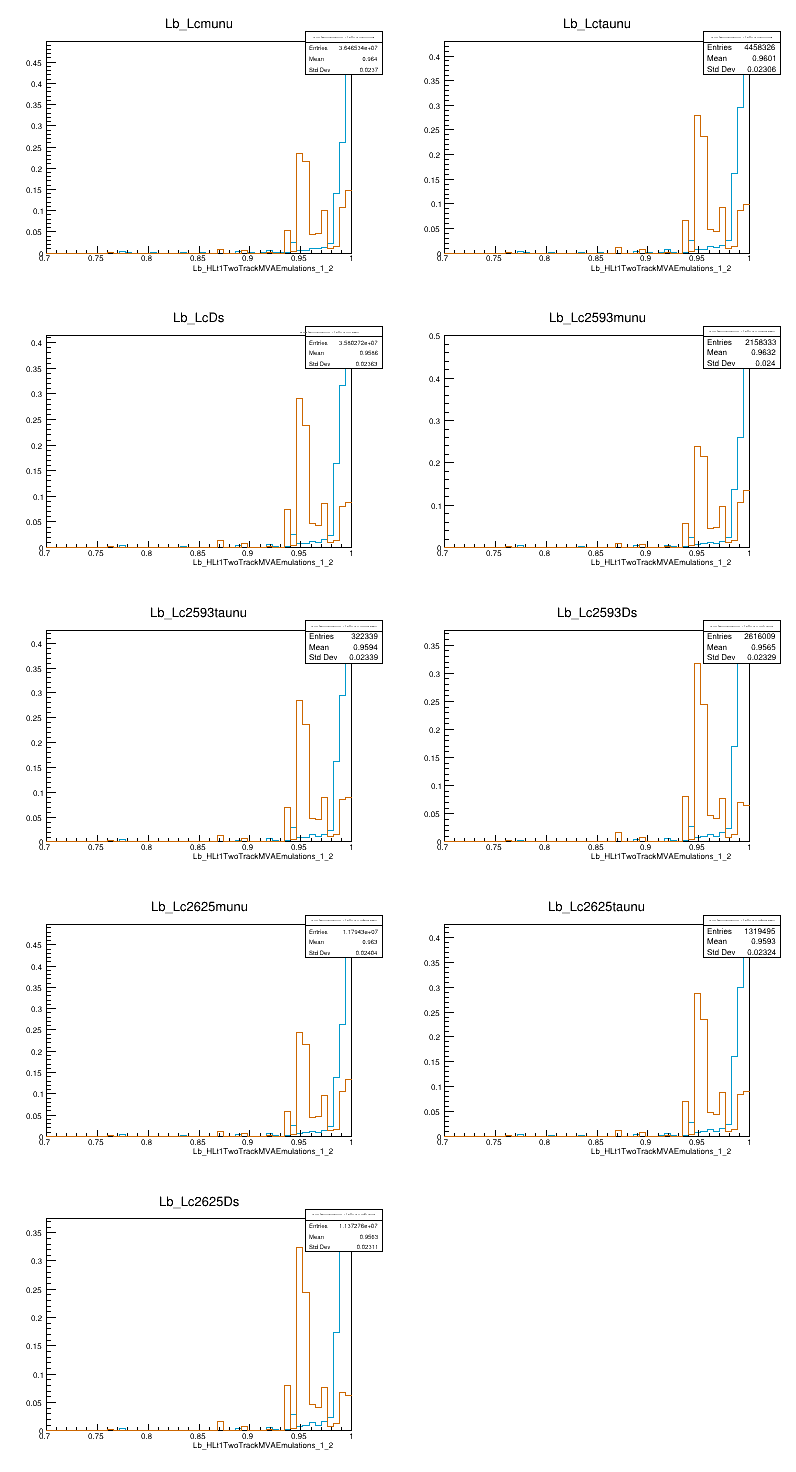

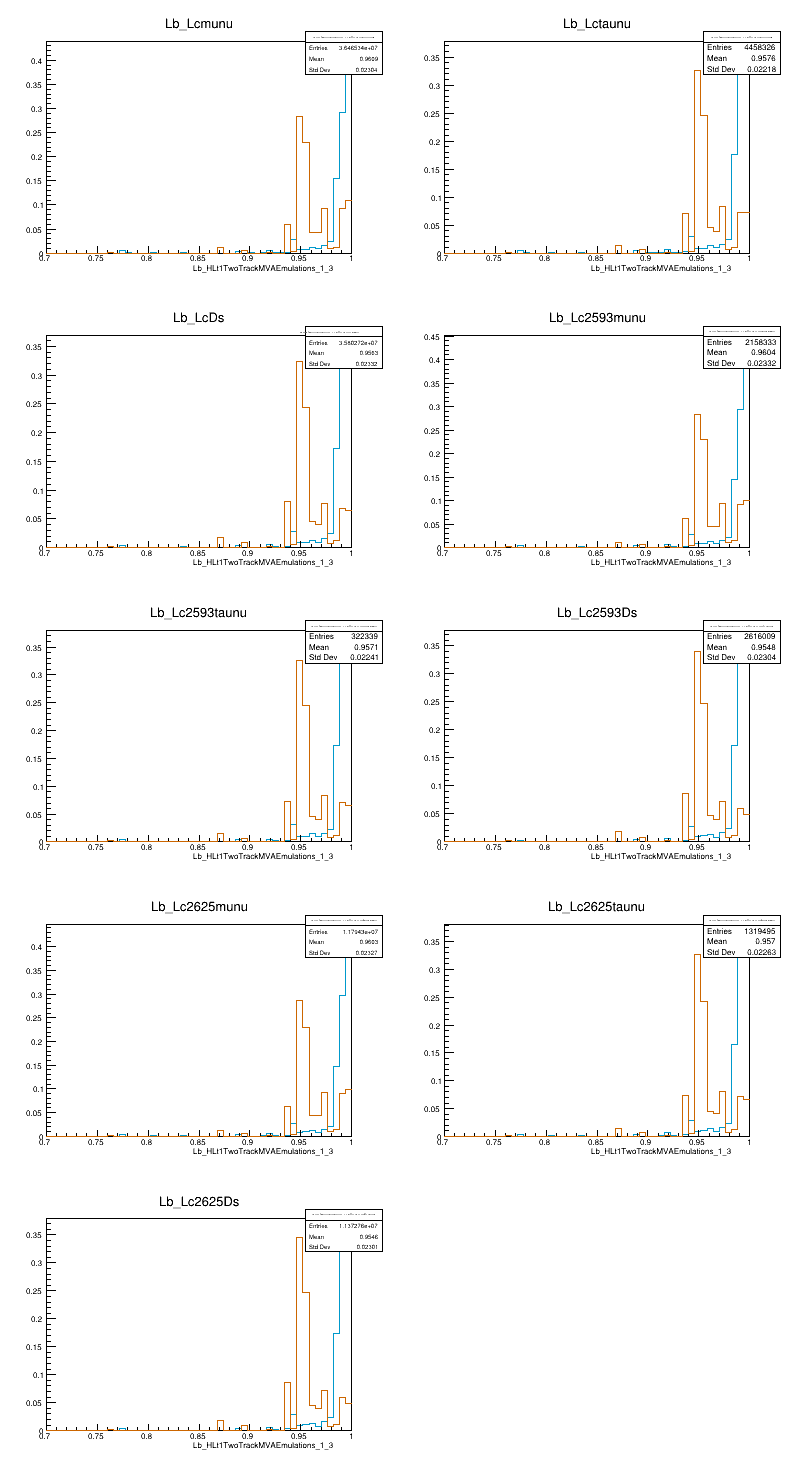

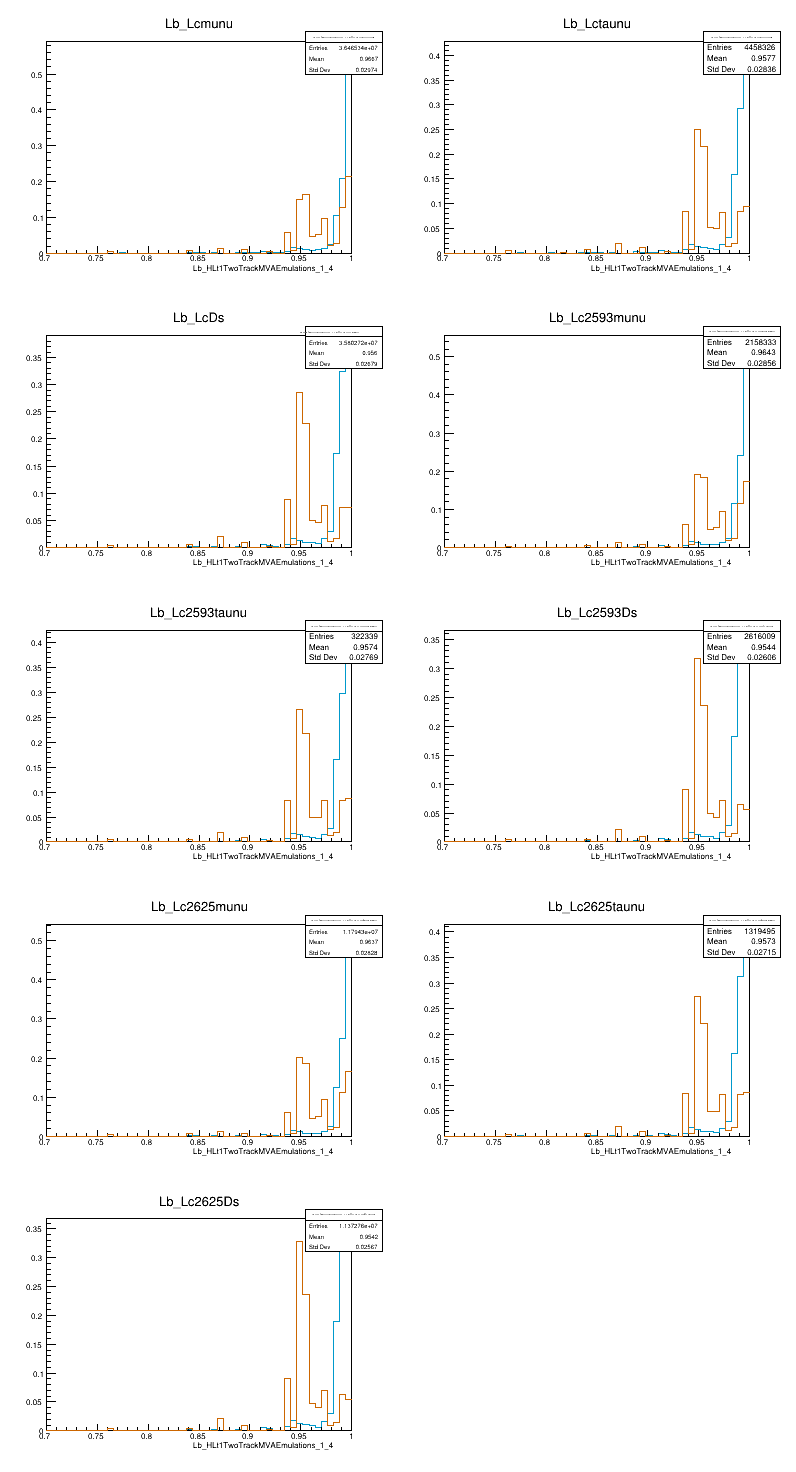

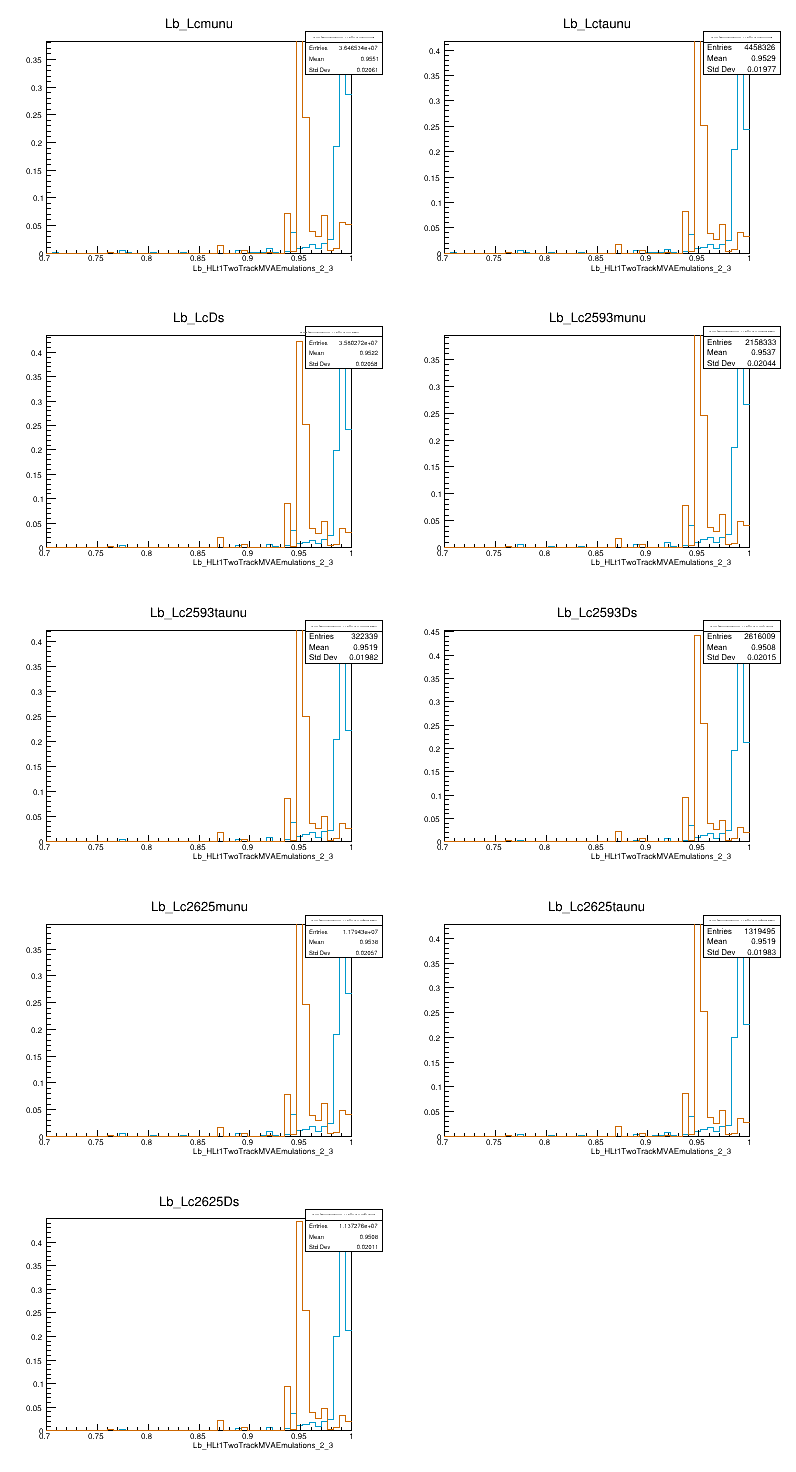

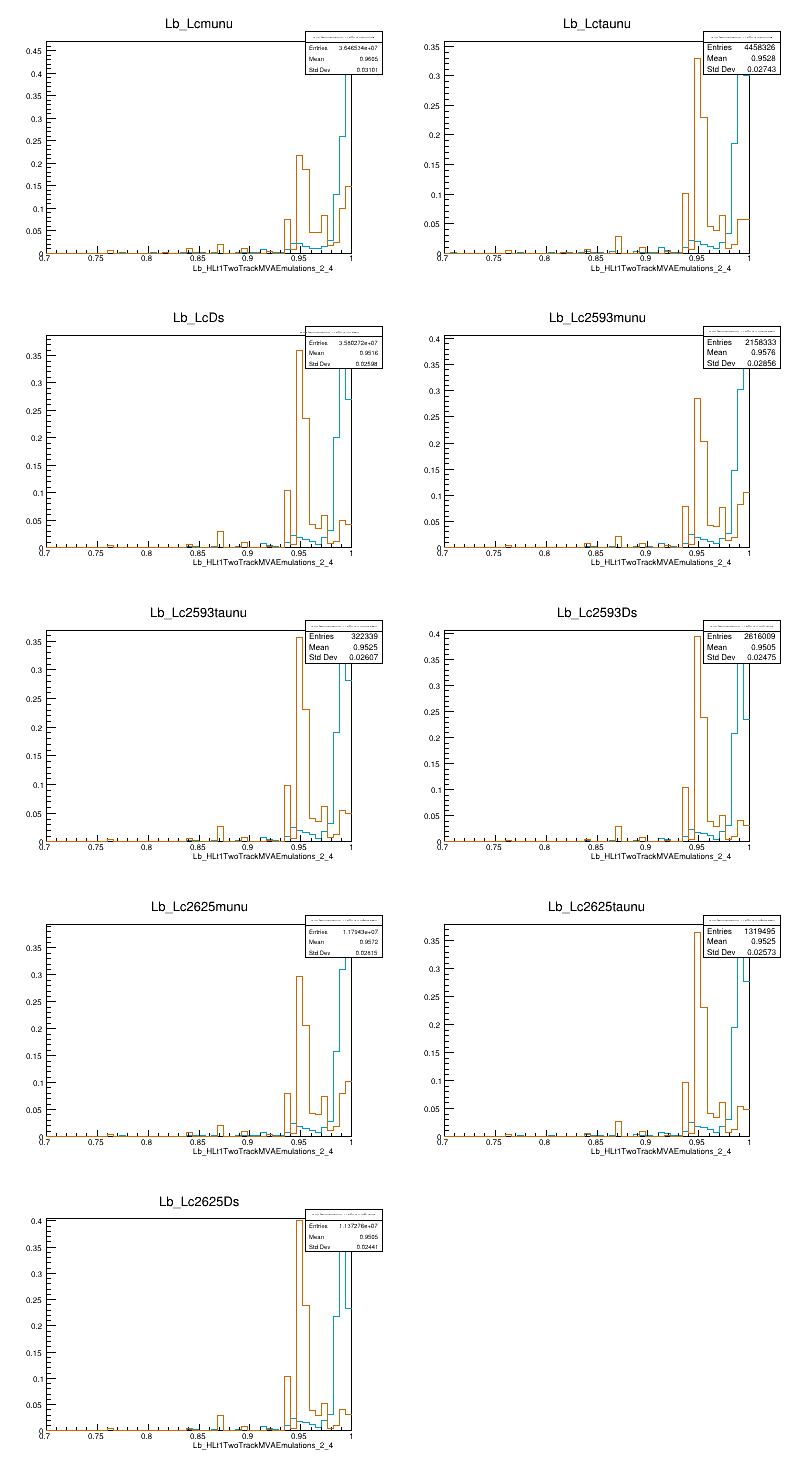

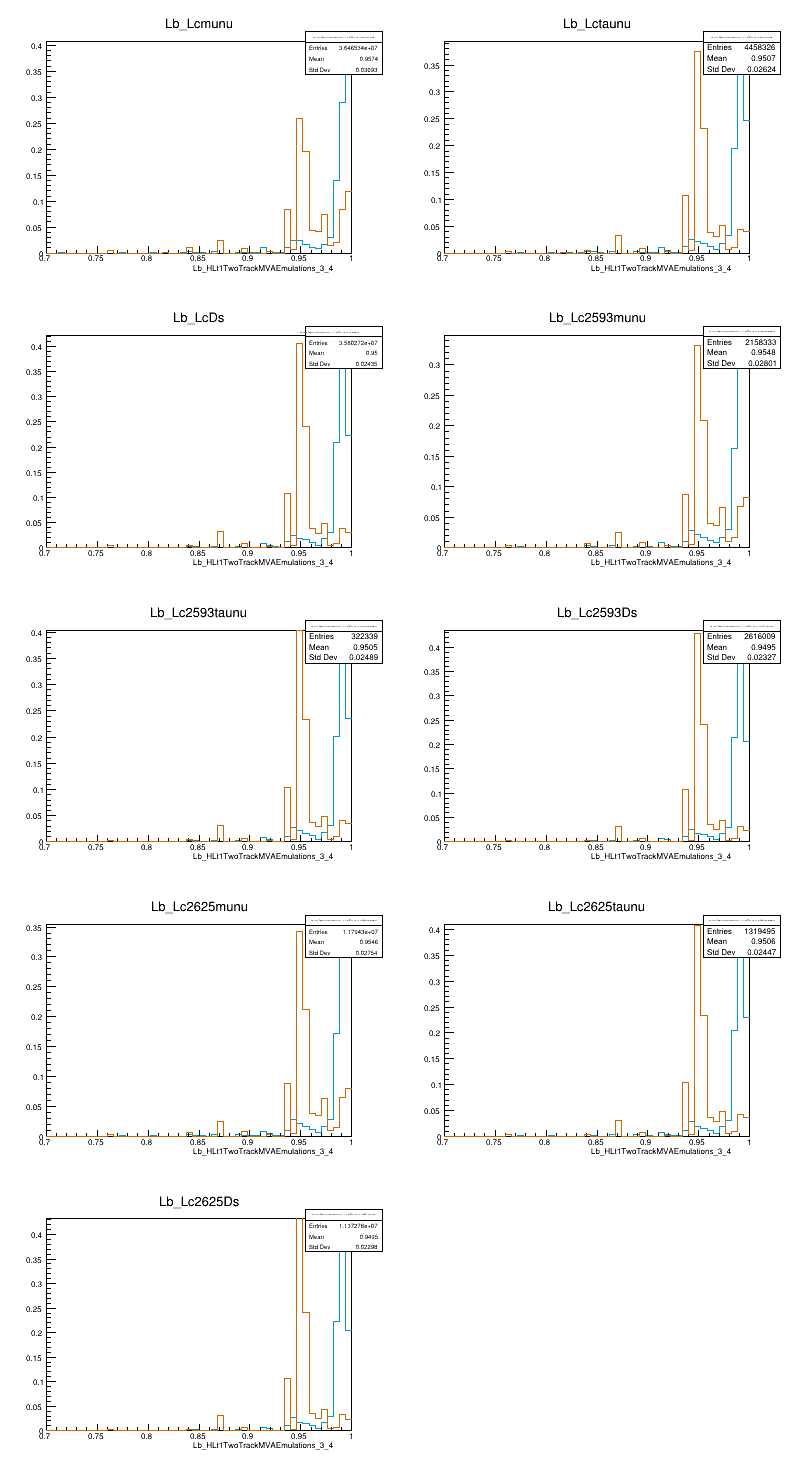

In [9]:
%jsroot on

c = {}
for key in variables:
    c[key] = PlotSuperimposed(key,hMCfull_scaled[key],hMCTO_scaled[key],key,'')
    c[key].Draw()

In [10]:
hMCfullO = {}
hMCTO_1 = {}
for variable in variables:
    print(variable)
    hMCfullO[variable],hMCTO_1[variable] = GetHistograms(variable,'old','MCTO')

Lb_HLt1TwoTrackMVAEmulations_1_2
Lb_Lcmunu
Lb_Lctaunu
Lb_LcDs
Lb_Lc2593munu
Lb_Lc2593taunu
Lb_Lc2593Ds
Lb_Lc2625munu
Lb_Lc2625taunu
Lb_Lc2625Ds
Lb_HLt1TwoTrackMVAEmulations_1_3
Lb_Lcmunu
Lb_Lctaunu
Lb_LcDs
Lb_Lc2593munu
Lb_Lc2593taunu
Lb_Lc2593Ds
Lb_Lc2625munu
Lb_Lc2625taunu
Lb_Lc2625Ds
Lb_HLt1TwoTrackMVAEmulations_1_4
Lb_Lcmunu
Lb_Lctaunu
Lb_LcDs
Lb_Lc2593munu
Lb_Lc2593taunu
Lb_Lc2593Ds
Lb_Lc2625munu
Lb_Lc2625taunu
Lb_Lc2625Ds
Lb_HLt1TwoTrackMVAEmulations_2_3
Lb_Lcmunu
Lb_Lctaunu
Lb_LcDs
Lb_Lc2593munu
Lb_Lc2593taunu
Lb_Lc2593Ds
Lb_Lc2625munu
Lb_Lc2625taunu
Lb_Lc2625Ds
Lb_HLt1TwoTrackMVAEmulations_2_4
Lb_Lcmunu
Lb_Lctaunu
Lb_LcDs
Lb_Lc2593munu
Lb_Lc2593taunu
Lb_Lc2593Ds
Lb_Lc2625munu
Lb_Lc2625taunu
Lb_Lc2625Ds
Lb_HLt1TwoTrackMVAEmulations_3_4
Lb_Lcmunu
Lb_Lctaunu
Lb_LcDs
Lb_Lc2593munu
Lb_Lc2593taunu
Lb_Lc2593Ds
Lb_Lc2625munu
Lb_Lc2625taunu
Lb_Lc2625Ds


In [11]:
hMCfullO_scaled, hMCTO_1_scaled = ScaleHistos(hMCfullO, hMCTO_1, 1)

Lb_HLt1TwoTrackMVAEmulations_1_2
Lb_HLt1TwoTrackMVAEmulations_1_3
Lb_HLt1TwoTrackMVAEmulations_1_4
Lb_HLt1TwoTrackMVAEmulations_2_3
Lb_HLt1TwoTrackMVAEmulations_2_4
Lb_HLt1TwoTrackMVAEmulations_3_4


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_Lb_HLt1TwoTrackMVAEmulations_1_2
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_Lb_HLt1TwoTrackMVAEmulations_1_3
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_Lb_HLt1TwoTrackMVAEmulations_1_4
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_Lb_HLt1TwoTrackMVAEmulations_2_3
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_Lb_HLt1TwoTrackMVAEmulations_2_4
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_Lb_HLt1TwoTrackMVAEmulations_3_4


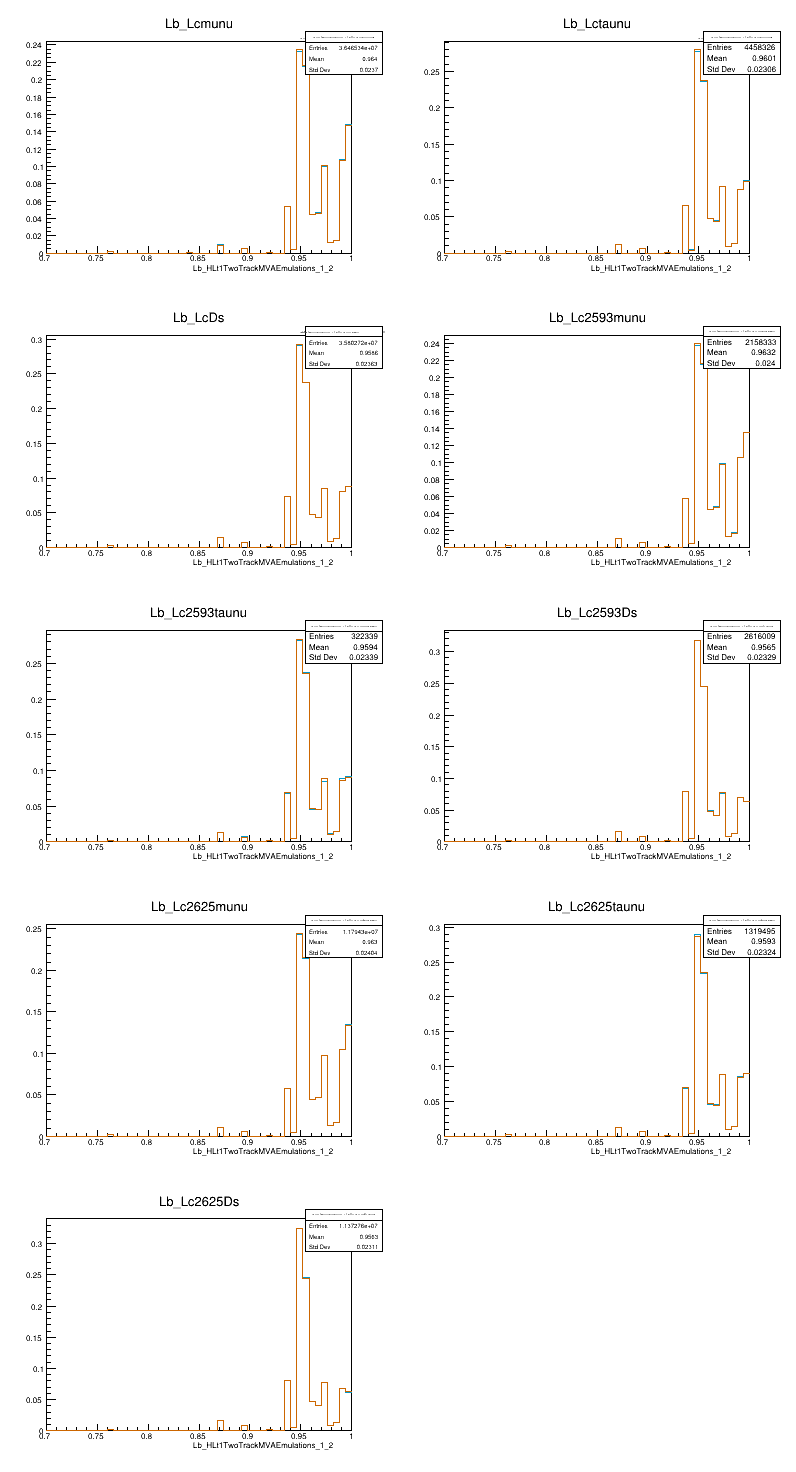

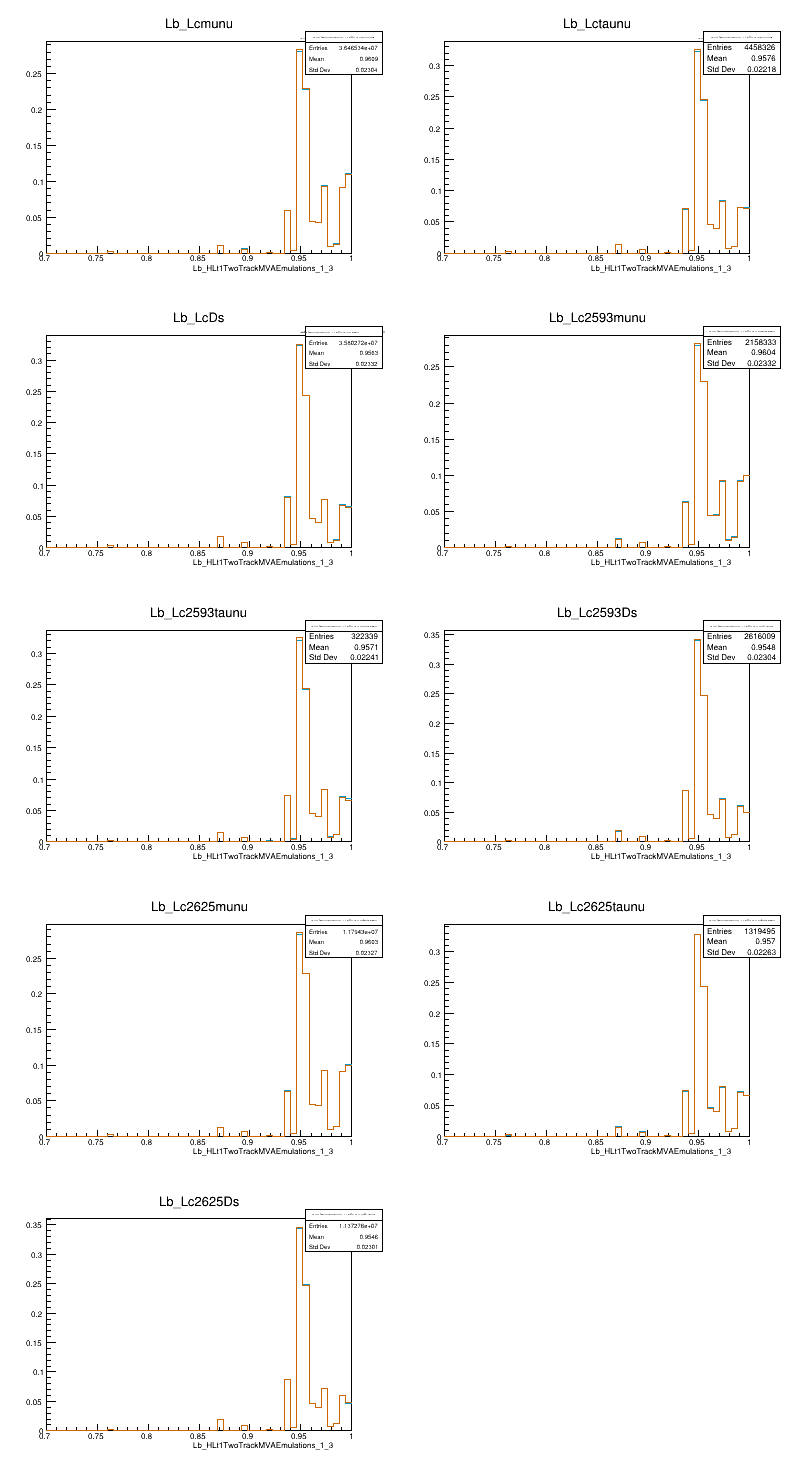

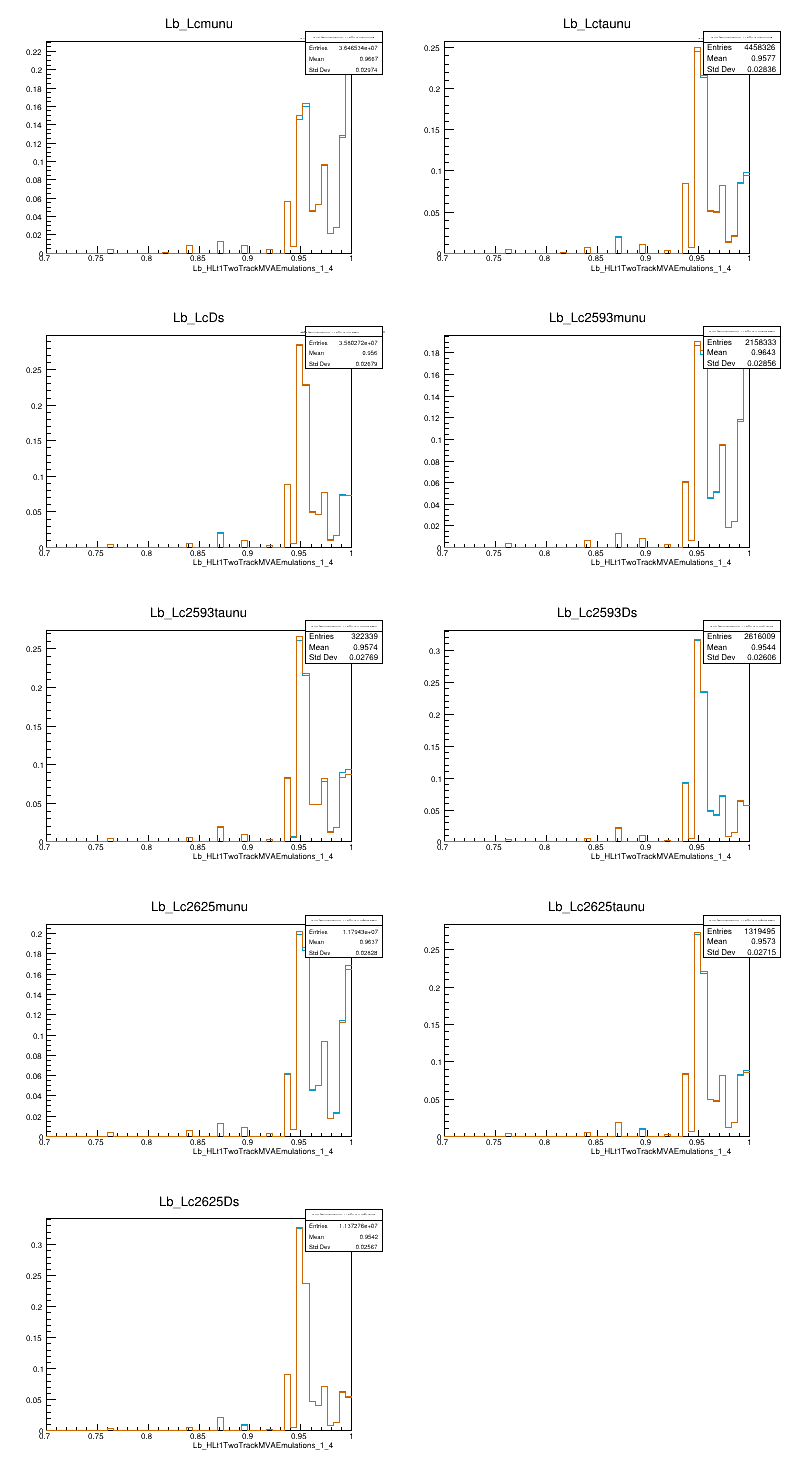

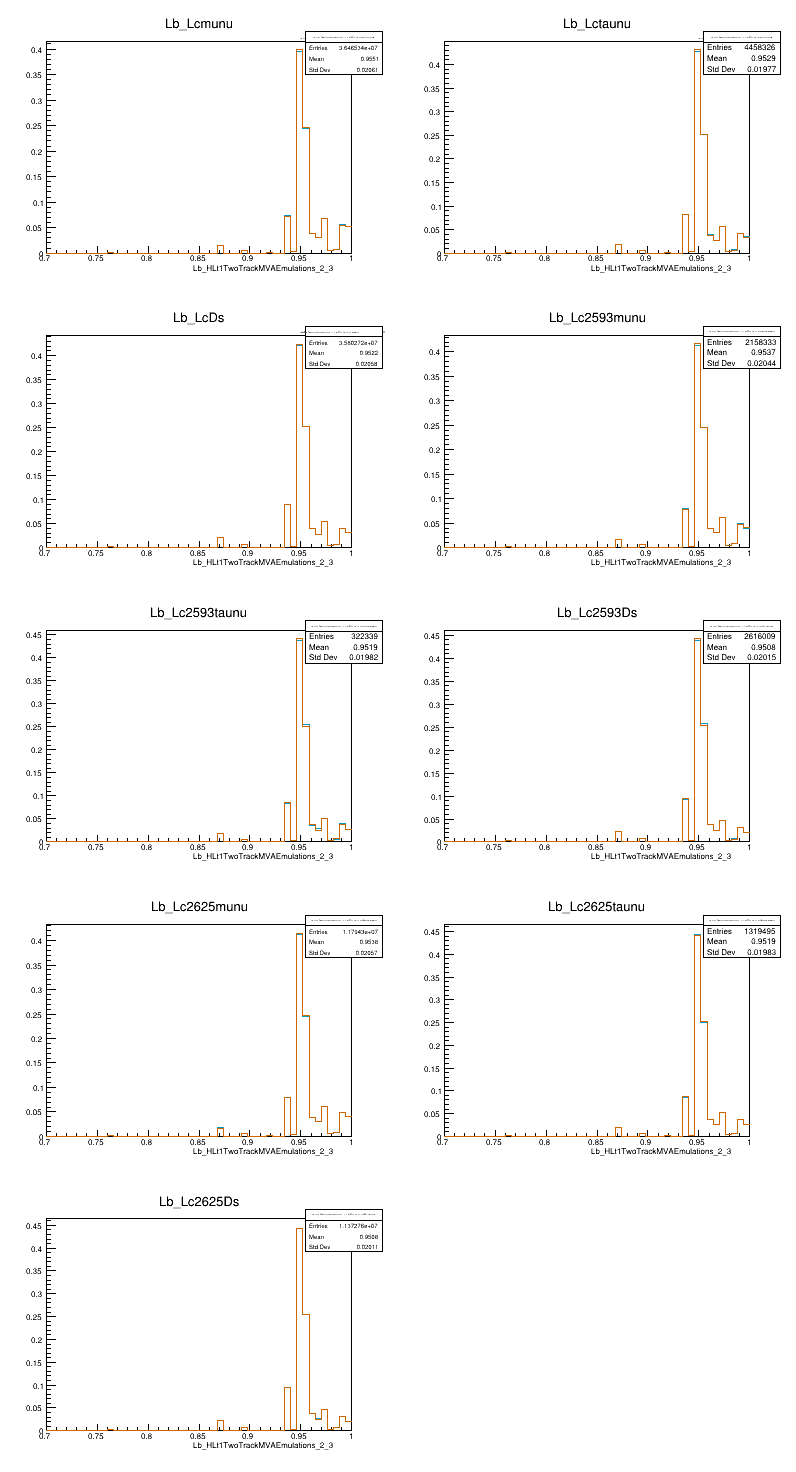

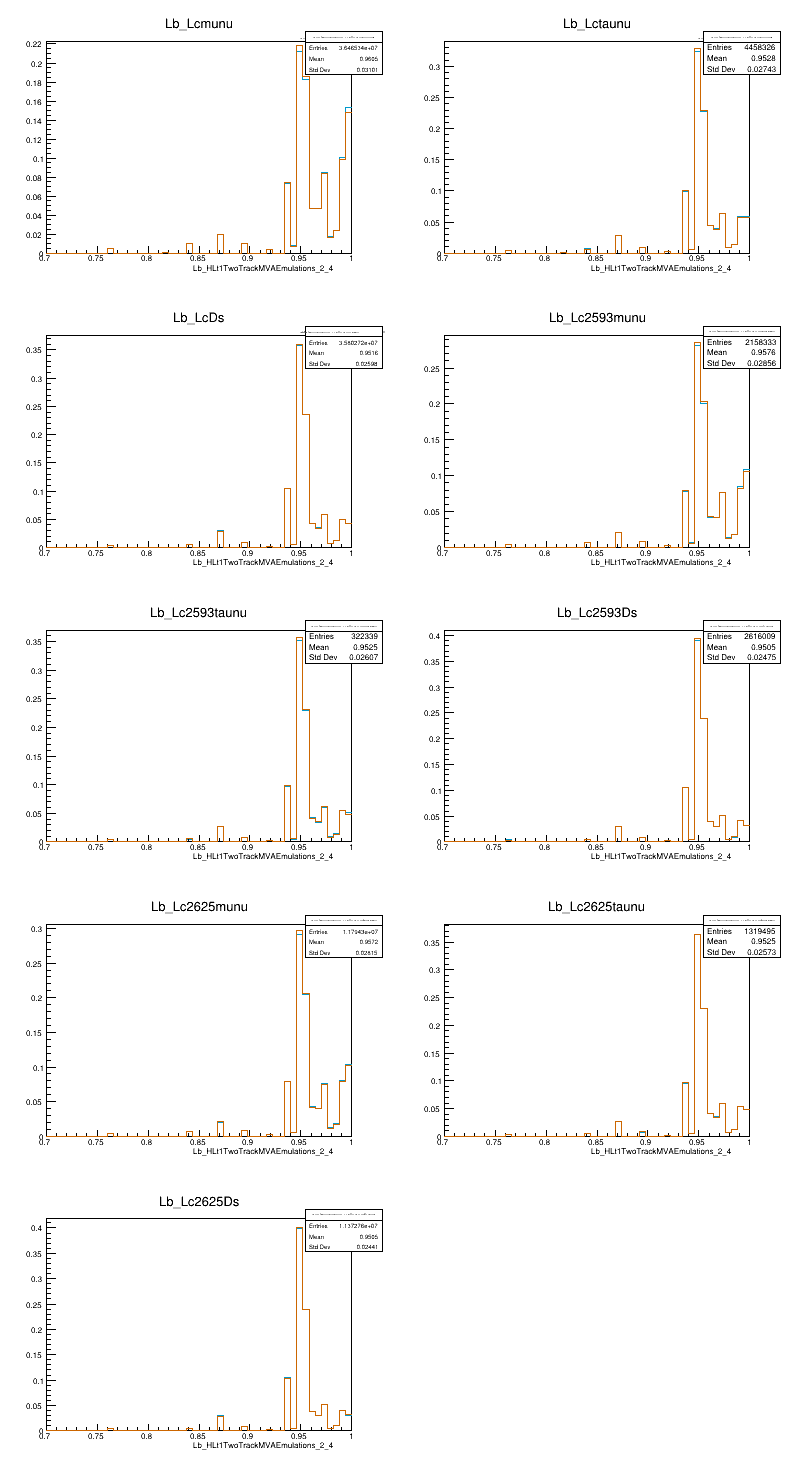

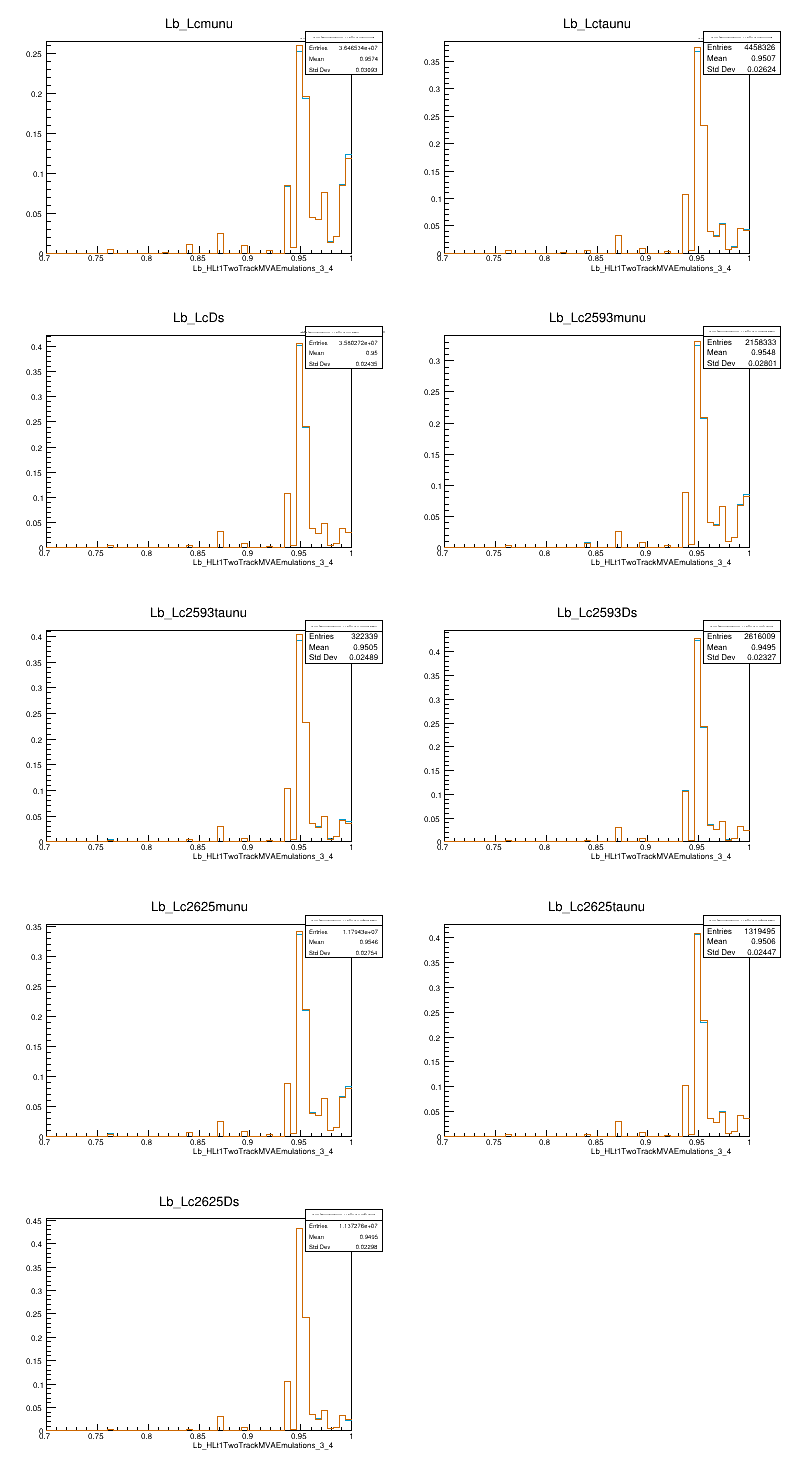

In [12]:
c1 = {}
for key in variables:
    c1[key] = PlotSuperimposed(key,hMCfullO_scaled[key],hMCTO_1_scaled[key],key,'')
    c1[key].Draw()

In [13]:
fMCfull = r.TFile(directory['new']+'Lb_Lcmunu_MagUp_full.root','READ')
t1 = fMCfull.Get('tupleout/DecayTree')
fMCTO = r.TFile('/disk/lhcb_data2/buonaura/LbLcmunu_MagUp_trackeronly_5000.root')
t2 = fMCTO.Get('tupleout/DecayTree')

In [18]:
hMCf = {variable:r.TH1F('hMCf_'+variable,'',50,0.7,1) for variable in variables}
hMCTO_2 = {variable:r.TH1F('hMCTO_'+variable,'',50,0.7,1) for variable in variables}
for variable in variables:  
    name = 'Lb_Lcmunu_MagUp'   
    t1.Draw(variable+'>>'+variable+'_MCfull_'+name+'(50,0.7,1)')
    hMCf[variable] = r.gPad.GetPrimitive(variable+'_MCfull_'+name)
            
    t2.Draw(variable+'>>'+variable+'_MCTO_'+name+'(50,0.7,1)')
    hMCTO_2[variable] = r.gPad.GetPrimitive(variable+'_MCTO_'+name)
    

In [22]:
def ScaleHistosSingle(h, h1, value):
    for key in variables:
        scale = value/h[key].Integral()
        h[key].Scale(scale)
        scale2 = value/h1[key].Integral()
        h1[key].Scale(scale2)
    return h, h1

In [23]:
hMCf_scaled, hMCTO_2_scaled = ScaleHistosSingle(hMCf, hMCTO_2, 1)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_Lb_HLt1TwoTrackMVAEmulations_1_2
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_Lb_HLt1TwoTrackMVAEmulations_1_3
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_Lb_HLt1TwoTrackMVAEmulations_1_4
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_Lb_HLt1TwoTrackMVAEmulations_2_3
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_Lb_HLt1TwoTrackMVAEmulations_2_4
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_Lb_HLt1TwoTrackMVAEmulations_3_4


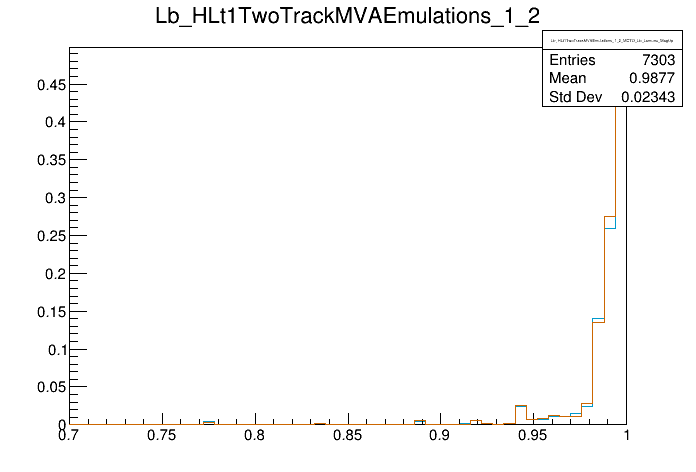

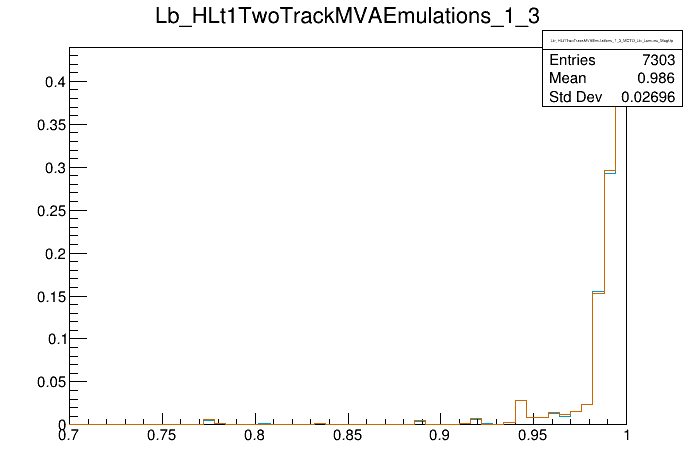

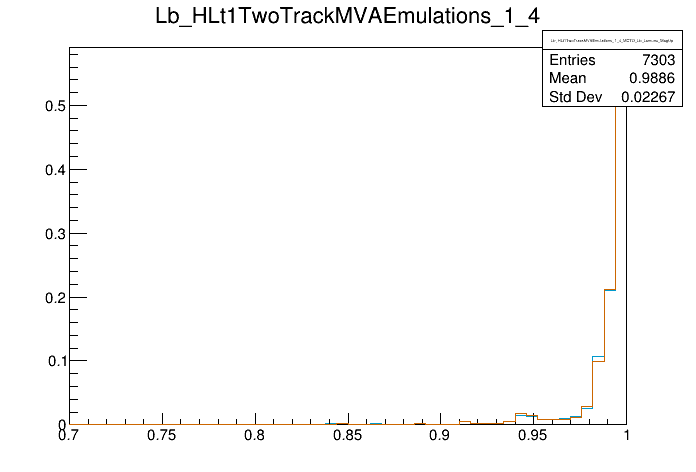

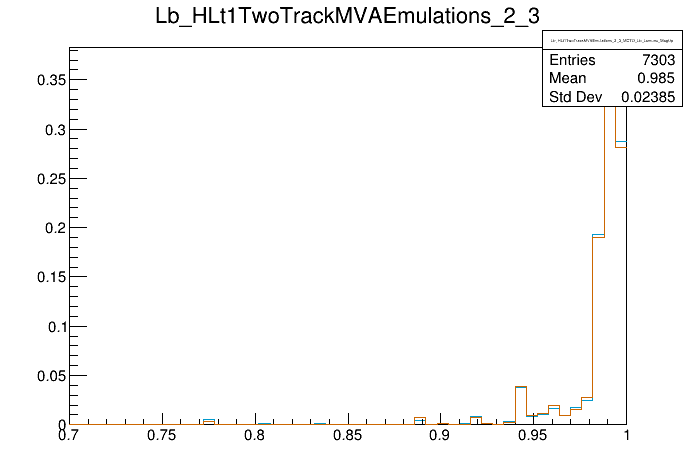

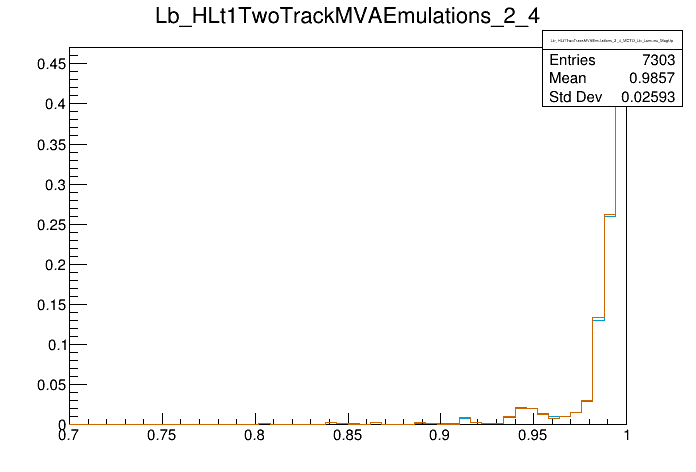

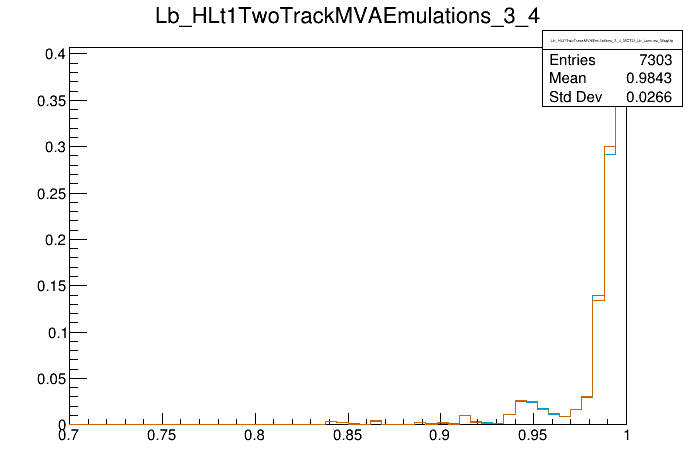

In [29]:
c2 = {}
for key in variables:
    c2[key] = PlotSuperimposedSingle(key,hMCf[key], hMCTO_2[key])
    c2[key].Draw()